In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591

from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
test_cands  = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()
print(len(dev_cands))

2814


In [8]:
from util import load_external_labels

# %time load_external_labels(session, Spouse, annotator_name='gold')

from snorkel.annotations import load_gold_labels

#L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

# L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
# L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
# gold_labels_dev = [L[0,0] if L[0,0]==1 else -1 for L in L_gold_dev]
gold_labels_dev = [L[0,0] for L in L_gold_dev]


from snorkel.learning.utils import MentionScorer

Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

# gold_labels_dev = []
# for i,L in enumerate(L_gold_dev):
#     gold_labels_dev.append(L[0,0])
    
# gold_labels_test = []
# for i,L in enumerate(L_gold_test):
#     gold_labels_test.append(L[0,0])
    
# print(len(gold_labels_dev),len(gold_labels_test))
# print(gold_labels_dev.count(1),gold_labels_dev.count(-1))
# print(len(gold_labels_dev))

print(gold_labels_dev.count(1),gold_labels_dev.count(0))
print(len(gold_labels_dev))

189 2625
2814


In [96]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../../../snorkel/tutorials/glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


In [11]:
# ####### Discrete ##########

# spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
# family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
#               'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
# family = family | {f + '-in-law' for f in family}
# other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# # Helper function to get last name
# def last_name(s):
#     name_parts = s.split(' ')
#     return name_parts[-1] if len(name_parts) > 1 else None    

# def LF_husband_wife(c):
#     return (1,1) if len(spouses.intersection(get_between_tokens(c))) > 0 else (0,0)

# def LF_husband_wife_left_window(c):
#     if len(spouses.intersection(get_left_tokens(c[0], window=2))) > 0:
#         return (1,1)
#     elif len(spouses.intersection(get_left_tokens(c[1], window=2))) > 0:
#         return (1,1)
#     else:
#         return (0,0)
    
# def LF_same_last_name(c):
#     p1_last_name = last_name(c.person1.get_span())
#     p2_last_name = last_name(c.person2.get_span())
#     if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
#         if c.person1.get_span() != c.person2.get_span():
#             return (1,1)
#     return (0,0)

# def LF_no_spouse_in_sentence(c):
#     return (-1,1) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

# def LF_and_married(c):
#     return (1,1) if 'and' in get_between_tokens(c) and 'married' in get_right_tokens(c) else (0,0)
    
# def LF_familial_relationship(c):
#     return (-1,1) if len(family.intersection(get_between_tokens(c))) > 0 else (0,0)

# def LF_family_left_window(c):
#     if len(family.intersection(get_left_tokens(c[0], window=2))) > 0:
#         return (-1,1)
#     elif len(family.intersection(get_left_tokens(c[1], window=2))) > 0:
#         return (-1,1)
#     else:
#         return (0,0)

# def LF_other_relationship(c):
#     return (-1,1) if len(other.intersection(get_between_tokens(c))) > 0 else (0,0)


# import bz2

# # Function to remove special characters from text
# def strip_special(s):
#     return ''.join(c for c in s if ord(c) < 128)

# # Read in known spouse pairs and save as set of tuples
# with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
#     known_spouses = set(
#         tuple(strip_special(x.decode('utf-8')).strip().split(',')) for x in f.readlines()
#     )
# # Last name pairs for known spouses
# last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
# def LF_distant_supervision(c):
#     p1, p2 = c.person1.get_span(), c.person2.get_span()
#     return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

# def LF_distant_supervision_last_names(c):
#     p1, p2 = c.person1.get_span(), c.person2.get_span()
#     p1n, p2n = last_name(p1), last_name(p2)
#     return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,0)


# LFs = [
#     LF_distant_supervision, LF_distant_supervision_last_names, 
#     LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
#     LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
#     LF_family_left_window, LF_other_relationship
# ]

In [92]:
##### Continuous ################


import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)


spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    global LF_Threshold
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for sw in spouses:
        sc=max(sc,get_similarity(word_vectors,sw))
    return (1,sc)

def LF_husband_wife_left_window(c):
    global LF_Threshold
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for sw in spouses:
        sc_1=max(sc_1,get_similarity(word_vectors,sw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for sw in spouses:
        sc_2=max(sc_2,get_similarity(word_vectors,sw))
    return(1,max(sc_1,sc_2))
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return (1,1)
    return (0,0)

def LF_no_spouse_in_sentence(c):
    return (-1,0.75) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

def LF_and_married(c):
    global LF_Threshold
    word_vectors = get_word_vectors(preprocess(get_right_tokens(c)))
    sc = get_similarity(word_vectors,'married')
    
    if 'and' in get_between_tokens(c):
        return (1,sc)
    else:
        return (0,0)

def LF_familial_relationship(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for fw in family:
        sc=max(sc,get_similarity(word_vectors,fw))
        
    return (-1,sc) 

def LF_family_left_window(c):
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for fw in family:
        sc_1=max(sc_1,get_similarity(word_vectors,fw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for fw in family:
        sc_2=max(sc_2,get_similarity(word_vectors,fw))
        
    return (-1,max(sc_1,sc_2))

def LF_other_relationship(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
        
    return (-1,sc) 

# def LF_other_relationship_left_window(c):
#     sc = 0
#     word_vectors = get_word_vectors(preprocess(get_left_tokens(c)))
#     for ow in other:
#         sc=max(sc,get_similarity(word_vectors,ow))
#     return (-1,sc) 

import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# # Read in known spouse pairs and save as set of tuples
# with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
#     known_spouses = set(
#         tuple(strip_special(x).strip().split(',')) for x in f.readlines()
#     )
# # Last name pairs for known spouses
# last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,1)

import numpy as np

# def LF_Three_Lists_Left_Window(c):
#     global softmax_Threshold
#     c1,s1 = LF_husband_wife_left_window(c)
#     c2,s2 = LF_family_left_window(c)
#     c3,s3 = LF_other_relationship_left_window(c)
#     sc = np.array([s1,s2,s3])
#     c = [c1,c2,c3]
#     sharp_param = 1.5
#     prob_sc = np.exp(sc * sharp_param - np.max(sc))
#     prob_sc = prob_sc / np.sum(prob_sc)
#     #print 'Left:',s1,s2,s3,prob_sc
    
#     if s1==s2 or s3==s1:
#         return (0,0)
#     return c[np.argmax(prob_sc)],1

# def LF_Three_Lists_Between_Words(c):
#     global softmax_Threshold
#     c1,s1 = LF_husband_wife(c)
#     c2,s2 = LF_familial_relationship(c)
#     c3,s3 = LF_other_relationship(c)
#     sc = np.array([s1,s2,s3])
#     c = [c1,c2,c3]
#     sharp_param = 1.5
    
#     prob_sc = np.exp(sc * sharp_param - np.max(sc))
#     prob_sc = prob_sc / np.sum(prob_sc)
#     #print 'BW:',s1,s2,s3,prob_sc
#     if s1==s2 or s3==s1:
#         return (0,0)
#     return c[np.argmax(prob_sc)],1
    
LFs = [
    LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
    LF_family_left_window, LF_other_relationship
]

In [99]:
''' output:

    [[[L_x1],[S_x1]],
     [[L_x2],[S_x2]],
     ......
     ......
    ]

'''
def get_L_S_Tensor(cands): 
    
    L_S = []
    for i,ci in enumerate(cands):
        L_S_ci=[]
        L=[]
        S=[]
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        L_S_ci.append(L)
        L_S_ci.append(S)
        L_S.append(L_S_ci) 
        if(i%500==0 and i!=0):
            print(str(i)+'data points labelled in',(time.time() - start_time)/60,'mins')
    return L_S


In [100]:
# import matplotlib.pyplot as plt
import time
import numpy as np
start_time = time.time()

lt = time.localtime()

print("started at: {}-{}-{}, {}:{}:{}".format(lt.tm_mday,lt.tm_mon,lt.tm_year,lt.tm_hour,lt.tm_min,lt.tm_sec))

dev_L_S = get_L_S_Tensor(dev_cands)

np.save("dev_L_S_smooth",np.array(dev_L_S))

train_L_S = get_L_S_Tensor(train_cands)
np.save("train_L_S_smooth",np.array(train_L_S))

print("--- %s seconds ---" % (time.time() - start_time))

# test_L_S = get_L_S_Tensor(test_cands)
# pkl.dump(test_L_S,open("test_L_S.p","wb"))

started at: 9-5-2018, 10:41:55
500data points labelled in 0.7188430507977803 mins
1000data points labelled in 1.3335495034853617 mins
1500data points labelled in 1.917067794005076 mins
2000data points labelled in 2.519752260049184 mins
2500data points labelled in 3.1769800662994383 mins
500data points labelled in 4.174797224998474 mins
1000data points labelled in 4.797278384367625 mins
1500data points labelled in 5.556176539262136 mins
2000data points labelled in 6.174566467603047 mins
2500data points labelled in 6.850887068112692 mins
3000data points labelled in 7.6337612748146055 mins
3500data points labelled in 8.271688584486643 mins
4000data points labelled in 8.86154446999232 mins
4500data points labelled in 9.401108086109161 mins
5000data points labelled in 10.001064256827037 mins
5500data points labelled in 10.652975161870321 mins
6000data points labelled in 11.262283476193746 mins
6500data points labelled in 11.85253625313441 mins
7000data points labelled in 12.50683133204778 m

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

def draw2DArray(a):
    fig = plt.figure(figsize=(6, 3.2))
    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    plt.imshow(np.array(a))
    ax.set_aspect('equal')
    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()
    
      
def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return pd.DataFrame(D_class_data).T

def predictAndPrint(pl):
    print("acc",accuracy_score(gold_labels_dev,pl))
#     print(precision_recall_fscore_support(true_labels,pl,average='macro'))
    print(confusion_matrix(gold_labels_dev,pl))
    draw2DArray(confusion_matrix(gold_labels_dev,pl))
    return report2dict(classification_report(gold_labels_dev, pl))# target_names=class_names))
    


def drawPRcurve(y_test,y_score,it_no):
    
    fig = plt.figure()
    splt = fig.add_subplot(111)
    

    precision, recall, _ = precision_recall_curve(y_test, y_score,pos_label=1)

    splt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    splt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    average_precision = average_precision_score(y_test, y_score)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('{0:d} Precision-Recall curve: AP={1:0.2f}'.format(it_no,
              average_precision))
    

def drawLossVsF1(y_loss,x_f1s,text,title):
    fig, ax = plt.subplots()
    ax.scatter(x_f1s, y_loss)

    plt.xlabel('f1-score')
    plt.ylabel('loss')
    plt.title(title)
    
    for i, txt in enumerate(text):
        ax.annotate(txt, (x_f1s[i],y_loss[i]))
        
    plt.savefig(title+".png")
    

In [101]:
LF_l = [
    1,1,1,1,1,-1,1,-1,-1,-1
]

In [216]:
import numpy as np
# dev_L_S = np.load("dev_L_S_smooth.npy")
# train_L_S = np.load("train_L_S_smooth.npy")

dev_L_S = np.load("dev_L_S_discrete.npy")
train_L_S = np.load("train_L_S_discrete.npy")
print(dev_L_S.shape,train_L_S.shape)

(2814, 2, 10) (22276, 2, 10)


In [103]:
#call this only once for a kernel startup
from __future__ import absolute_import, division, print_function

import tensorflow as tf
# BATCH_SIZE = 32

In [104]:
NoOfLFs= len(LFs)
NoOfClasses = 2
print(len(LFs),len(LF_l))

10 10


In [405]:
## normalized loss with prior from other LFs

def train_nlp(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        
        
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)

#         ls_ = tf.multiply(l,s_)

#         nls_ = tf.multiply(l,s_)*-1
               
        
        pout = tf.map_fn(lambda li: tf.map_fn(lambda lij:li*lij,li ),l)
#         print("nls",nls_)
        print("pout",pout)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        

        sumy = tf.reduce_sum(t_pout-logz,axis=1)
        print("sumy",sumy)
    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_sum(t_pout-logz,axis=1) ))

        
        def index_along_every_row(array, index):
            N, _ = array.shape
            return array[np.arange(N), index]

        #Best LF
        blf = tf.argmax(t_pout,axis=1)
        print("blf",blf)
        print("normloss",normloss)
        
        
        marginals = tf.py_func(index_along_every_row, [tf.squeeze(t_pout), tf.squeeze(blf)], [tf.float64])[0]

        print("marginals",marginals)
        predict1 = tf.gather(k,tf.squeeze(blf))
        
        predict = tf.where(tf.equal(predict1,1),tf.ones_like(predict1),tf.zeros_like(predict1))
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl,b = sess.run([alphas,thetas,marginals,predict,blf])
                print(b)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


                unique, counts = np.unique(b.tolist(), return_counts=True)
                print(dict(zip(unique, counts)))
                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict,blf])
            print(b)
            print(t)

#             MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [406]:
train_nlp(0.1/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 10, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 10, 1), dtype=float64)
t_k Tensor("mul:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
sumy Tensor("Sum_1:0", shape=(?, 1), dtype=float64)
blf Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("PyFunc:0", dtype=float64)
predict Tensor("Select:0", dtype=float64)
0 loss 2013128.8891574587
[[5]
 [5]
 [0]
 ...
 

ValueError: too many values to unpack (expected 4)

In [404]:
#print blf
train_nlp(0.1/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 10, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 10, 1), dtype=float64)
t_k Tensor("mul:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
sumy Tensor("Sum_1:0", shape=(?, 1), dtype=float64)
blf Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("PyFunc:0", dtype=float64)
predict Tensor("Select:0", dtype=float64)
0 loss 2013128.8891574587
[[5]
 [5]
 [0]
 ...
 

ValueError: too many values to unpack (expected 4)

In [370]:
#input L_S:train_L_S, K: no of classes

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def get_maj_prior(L_S,K):
    maj_prior = []
    
    print(L_S[:,0,:].shape)
    for row in np.nditer(L_S[:,0,:],flags=['external_loop'], order='C'):
        p = np.ones(K)/K
        unique, counts = np.unique(row, return_counts=True)
        unique = [int(x) for x in unique]
        rc = dict(zip(unique, counts))
        tnz = np.count_nonzero(row)
        if -1 in rc:
            p[0] = rc[-1]
        if 1 in rc:
            p[1] = rc[1]
        p = softmax(p)
        maj_prior.append(p)
    return np.array(maj_prior)

dev_maj_pl=get_maj_prior(dev_L_S,2)
print(dev_maj_pl.shape)


train_maj_pl=get_maj_prior(train_L_S,2)
print(train_maj_pl.shape)

(2814, 10)
(2814, 2)
(22276, 10)
(22276, 2)


In [393]:
## Normalized loss with majority prior



def train_nlmp(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])
        
        maj_train_dataset = tf.data.Dataset.from_tensor_slices(train_maj_pl).batch(BATCH_SIZE)
        maj_dev_dataset = tf.data.Dataset.from_tensor_slices(dev_maj_pl).batch(dev_maj_pl.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        
        maj_iterator = tf.data.Iterator.from_structure(maj_train_dataset.output_types,
                                               maj_train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        maj_train_init_op = maj_iterator.make_initializer(maj_train_dataset)
       
        dev_init_op = iterator.make_initializer(dev_dataset)
        maj_dev_init_op = maj_iterator.make_initializer(maj_dev_dataset)

        next_element = iterator.get_next()
        maj_prior = tf.transpose(maj_iterator.get_next())
        print("maj_label",maj_prior)
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)
        stpout= tf.squeeze(t_pout)
        print("stpout",stpout)
        prod = tf.reduce_sum(maj_prior*stpout,axis=0)
        print("prod",prod)
     

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_sum(maj_prior*tf.squeeze(t_pout-logz),axis=1) ))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                sess.run(maj_train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                sess.run(maj_dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
                print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            sess.run(maj_dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [396]:
train_nlmp(0.1/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12)) 

maj_label Tensor("transpose:0", shape=(2, ?), dtype=float64)
next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
stpout Tensor("Squeeze_1:0", dtype=float64)
prod Tensor("Sum_1:0", dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_2:0", shape=(2

In [401]:
## Normalized loss with majority bias un-normalized



def train_unlmp(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])
        
        maj_train_dataset = tf.data.Dataset.from_tensor_slices(train_maj_pl).batch(BATCH_SIZE)
        maj_dev_dataset = tf.data.Dataset.from_tensor_slices(dev_maj_pl).batch(dev_maj_pl.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        
        maj_iterator = tf.data.Iterator.from_structure(maj_train_dataset.output_types,
                                               maj_train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        maj_train_init_op = maj_iterator.make_initializer(maj_train_dataset)
       
        dev_init_op = iterator.make_initializer(dev_dataset)
        maj_dev_init_op = maj_iterator.make_initializer(maj_dev_dataset)

        next_element = iterator.get_next()
        maj_prior = tf.transpose(maj_iterator.get_next())
        print("maj_label",maj_prior)
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)
        stpout= tf.squeeze(t_pout)
        print("stpout",stpout)
        prod = tf.reduce_sum(maj_prior*stpout,axis=0)
        print("prod",prod)
     

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_sum(maj_prior*tf.squeeze(t_pout),axis=1) ))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                sess.run(maj_train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                sess.run(maj_dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
                print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            sess.run(maj_dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [402]:
train_unlmp(0.1/len(train_L_S),5,tf.truncated_normal_initializer(1,0.1,12)) 

maj_label Tensor("transpose:0", shape=(2, ?), dtype=float64)
next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
stpout Tensor("Squeeze_1:0", dtype=float64)
prod Tensor("Sum_1:0", dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_2:0", shape=(2

In [290]:
## normalized training with different params

def train_nl(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
        print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
                print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [222]:
## Objective value Normalized

def getNLObjValue(th):
    BATCH_SIZE = 1
    tf.reset_default_graph()

    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.convert_to_tensor(th)

        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)
        print("thetas",thetas)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
        print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) - logz))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
    #     train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            tl = 0
            for it in range(1):
                sess.run(train_init_op)
                
                try:
                    while True:
    #                     _,ls = sess.run([train_step,normloss])
                        ls = sess.run(normloss) # to calculate loss on fixed thetas
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"train loss",tl)

#                 sess.run(dev_init_op)
#                 a,t,m,pl,dl = sess.run([alphas,thetas,marginals,predict,normloss])
#                  print(a)
#                 print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
#                 print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
#                 print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl,dl = sess.run([alphas,thetas,marginals,predict,normloss])
            print(a)
            print(t)
            print("dev loss",dl)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            res = precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary")
            return (tl,dl,res)

print("snorkel thetas")
l_f1s = []
#snorkel thetas
l_f1s.append(getNLObjValue(np.array([[ 0.07472098,  0.07514459,  0.11910277,\
                0.11186369,0.07306518,0.69216714,0.07467749,0.16012659,\
                    0.13682546,0.08183363]])))
 
            
print(" un-norma thetas ep7 ")

# l_f1s.append(getNLObjValue(np.array([[1.0,1.0,1.0,1.0,1.0,1.02750979,\
#                              1.0,1.0218145,1.0,1.0]])))

l_f1s.append(getNLObjValue(np.array([[0.33293226,0.01940464,0.42274838,0.39655883,\
    0.31731244,0.84775084,0.37180681,0.46009105,0.5502137,0.32638473]])))

print(l_f1s)

snorkel thetas
next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
k Tensor("Const_2:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
thetas Tensor("Const_1:0", shape=(1, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int

In [217]:
# init random thetas

train_nl(0.1/len(train_L_S),15,tf.truncated_normal_initializer(1,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

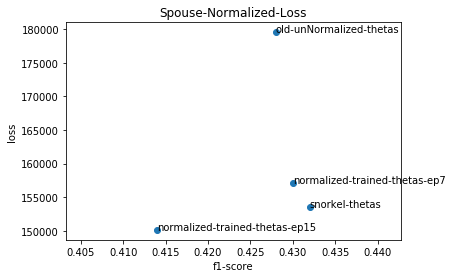

In [234]:
## Normalized loss plot loss vs f1s


  
    
y_loss=[153548.149,179552.66,157032.751,150114.45]
x_f1s =[0.432,0.428,0.43,0.414]
text=["snorkel-thetas","old-unNormalized-thetas","normalized-trained-thetas-ep7",\
      "normalized-trained-thetas-ep15"]
drawLossVsF1(y_loss,x_f1s,text,"Spouse-Normalized-Loss")





In [173]:
## Objective value on snorkel thetas Unnormalized # remove logz from obj

def getUNLObjValue(th):
    BATCH_SIZE = 1
    tf.reset_default_graph()

    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.convert_to_tensor(th)

        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)
        print("thetas",thetas)

    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
        print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0) ))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
    #     train_step = tf.train.AdamOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            tl = 0
            for it in range(1):
                sess.run(train_init_op)
                
                try:
                    while True:
    #                     _,ls = sess.run([train_step,normloss])
                        ls = sess.run(normloss) # to calculate loss on fixed thetas
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"train loss",tl)

#                 sess.run(dev_init_op)
#                 a,t,m,pl,dl = sess.run([alphas,thetas,marginals,predict,normloss])
#                  print(a)
#                 print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


#                 unique, counts = np.unique(pl, return_counts=True)
#                 print(dict(zip(unique, counts)))
#                 print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
#                 print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl,dl = sess.run([alphas,thetas,marginals,predict,normloss])
            print(a)
            print(t)
            print("dev loss",dl)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
            res = precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary")
            return (tl,dl,res)

print("snorkel thetas")
l_f1s = []
#snorkel thetas
l_f1s.append(getUNLObjValue(np.array([[ 0.07472098,  0.07514459,  0.11910277,\
                0.11186369,0.07306518,0.69216714,0.07467749,0.16012659,\
                    0.13682546,0.08183363]])))
 
            
print("normalized thetas ep6 f10.43")

l_f1s.append(getUNLObjValue(np.array([[0.48198891,0.38912505,0.70829843,0.67643395,0.56100246,\
        1.39815618,0.49929654,0.83071361,0.8706048,0.6070296 ]])))

print(l_f1s)

snorkel thetas
next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
k Tensor("Const_2:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
thetas Tensor("Const_1:0", shape=(1, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int

In [182]:
## Un normalized training with different params

def train_unl(lr,ep,th):
    
    BATCH_SIZE = 1
    tf.reset_default_graph()


    seed = 12
    with tf.Graph().as_default():

        train_dataset = tf.data.Dataset.from_tensor_slices(train_L_S).batch(BATCH_SIZE)
        dev_dataset = tf.data.Dataset.from_tensor_slices(dev_L_S).batch(dev_L_S.shape[0])

        labels = tf.convert_to_tensor(gold_labels_dev)
        iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_init_op = iterator.make_initializer(train_dataset)
        dev_init_op = iterator.make_initializer(dev_dataset)

        next_element = iterator.get_next()
        print("next_element",next_element)

        alphas = tf.get_variable('alphas', [NoOfLFs],\
                                 initializer=tf.truncated_normal_initializer(0.2,0.1,seed),\
                                 dtype=tf.float64)

    #     thetas = tf.get_variable('thetas', [1,NoOfLFs],\
    #                              initializer=tf.truncated_normal_initializer(1,0.1,seed),\
    #                              dtype=tf.float64)

        thetas = tf.get_variable('thetas',[1,NoOfLFs],\
                                initializer=th,\
                        dtype=tf.float64)

        print("thetas",thetas)
        k = tf.convert_to_tensor(LF_l, dtype=tf.float64)
        print("k",k)
        print(alphas.graph)
        print(thetas.graph)
        l,s =  tf.unstack(next_element,axis=1)
        print(alphas)
        print(s)
        print("l",l)
        print(s.graph)

        s_ = tf.map_fn(lambda x : tf.maximum(tf.subtract(x,alphas), 0), s)



        ls_ = tf.multiply(l,s_)

        nls_ = tf.multiply(l,s_)*-1

        pout = tf.map_fn(lambda x: l*x,np.array([-1,1],dtype=np.float64))
        print("nls",nls_)


    #     lst = tf.matmul(ls_,thetas)
    #     print("lst",lst)
        t_pout = tf.map_fn(lambda x: tf.matmul(x,thetas,transpose_b=True),pout)
        print("pout",pout)

        print("t_pout",t_pout)

        t_k =  k*tf.squeeze(thetas)
        print("t_k",t_k)

        zy = tf.map_fn(lambda y: tf.reduce_prod(1+tf.exp(t_k*y),axis=0),np.array([-1,1],dtype=np.float64))

        logz = tf.log(tf.reduce_sum(zy,axis=0))
        print("zy",zy)
        print("logz",logz)

        lsp = tf.reduce_logsumexp(t_pout)
        print("lsp",lsp)

    #     normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)) - logz)  # add z

        normloss = tf.negative(tf.reduce_sum(tf.reduce_logsumexp(t_pout,axis=0)))


        print("normloss",normloss)
        marginals = tf.nn.softmax(t_pout,axis=0)

        print("marginals",marginals)
        predict = tf.argmax(marginals,axis=0)
        print("predict",predict)

    #     pre = tf.metrics.precision(labels,predict)
    #     rec = tf.metrics.recall(labels,predict)
    #     print("loss",loss)
    #     print("nls_",nls_)

    #     global_step = tf.Variable(0, trainable=False,dtype=tf.float64)
    #     starter_learning_rate = 1.0
    #     learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
    #                                            10, 0.96, staircase=True)
    #     train_step = tf.train.AdamOptimizer(learning_rate).minimize(normloss, global_step=global_step) 


    #     train_step = tf.train.AdamOptimizer(0.001).minimize(normloss)
    #     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #     reg_constant = 5.0  # Choose an appropriate one.
    #     totalloss = normloss + reg_constant * sum(reg_losses)
        train_step = tf.train.AdamOptimizer(lr).minimize(normloss) 
    #     train_step = tf.train.AdagradOptimizer(0.01).minimize(normloss) 
    #     train_step = tf.train.MomentumOptimizer(0.01,0.2).minimize(normloss) 

    #     train_step = tf.train.GradientDescentOptimizer(0.1).minimize(normloss)

        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_g)
            sess.run(init_l)

            # Initialize an iterator over the training dataset.
            for it in range(ep):
                sess.run(train_init_op)
                tl = 0
                try:
                    while True:
                        _,ls = sess.run([train_step,normloss])
                        tl = tl + ls
                except tf.errors.OutOfRangeError:
                    pass
                print(it,"loss",tl)

                sess.run(dev_init_op)
                a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
                print(a)
                print(t)


    #         MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


                unique, counts = np.unique(pl, return_counts=True)
                print(dict(zip(unique, counts)))
                print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))
                print()

            # Initialize an iterator over the validation dataset.
            sess.run(dev_init_op)
            a,t,m,pl = sess.run([alphas,thetas,marginals,predict])
            print(a)
            print(t)

            MentionScorer(dev_cands, L_gold_dev).score(m[1::].flatten())


            unique, counts = np.unique(pl, return_counts=True)
            print(dict(zip(unique, counts)))

            print("acc",accuracy_score(gold_labels_dev,pl))

            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl)))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="macro"))
            cf = confusion_matrix(gold_labels_dev,pl)
            print(cf)
            print("prec: tp/(tp+fp)",cf[1][1]/(cf[1][1]+cf[0][1]),"recall: tp/(tp+fn)",cf[1][1]/(cf[1][1]+cf[1][0]))
            print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(pl),average="binary"))

In [179]:
#init with old network thetas
# train_unl(0.01,15,np.array([[1.0,1.0,1.0,\
#                 1.0,1.0,1.02750979,1.0,1.0218145,1.0,1.0]]))   

train_unl(0.1/len(train_L_S),15,tf.constant_initializer(np.array([[1.0,1.0,1.0,\
                1.0,1.0,1.02750979,1.0,1.0218145,1.0,1.0]]))) 


next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

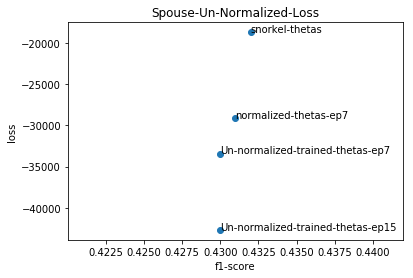

In [235]:
## UN-Normalized loss plot loss vs f1s
    
y_loss=[-18693.37,-29153.74,-33418.08,-42678.89]
x_f1s =[0.432,0.431,0.43,0.43]
text=["snorkel-thetas","normalized-thetas-ep7","Un-normalized-trained-thetas-ep7","Un-normalized-trained-thetas-ep15"]
drawLossVsF1(y_loss,x_f1s,text,"Spouse-Un-Normalized-Loss")


In [183]:
# init random thetas
train_unl(0.1/len(train_L_S),15,tf.truncated_normal_initializer(0.2,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

In [183]:
# LFS init random thetas

train_unl(0.1/len(train_L_S),15,tf.truncated_normal_initializer(0.2,0.1,12)) 

next_element Tensor("IteratorGetNext_1:0", shape=(?, 2, 10), dtype=float64)
thetas <tf.Variable 'thetas:0' shape=(1, 10) dtype=float64_ref>
k Tensor("Const_1:0", shape=(10,), dtype=float64)
<tf.Variable 'alphas:0' shape=(10,) dtype=float64_ref>
Tensor("unstack:1", shape=(?, 10), dtype=float64)
l Tensor("unstack:0", shape=(?, 10), dtype=float64)
nls Tensor("mul:0", shape=(?, 10), dtype=float64)
pout Tensor("map_1/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 10), dtype=float64)
t_pout Tensor("map_2/TensorArrayStack/TensorArrayGatherV3:0", shape=(2, ?, 1), dtype=float64)
t_k Tensor("mul_1:0", shape=(10,), dtype=float64)
zy Tensor("map_3/TensorArrayStack/TensorArrayGatherV3:0", shape=(2,), dtype=float64)
logz Tensor("Log:0", shape=(), dtype=float64)
lsp Tensor("ReduceLogSumExp/add:0", shape=(), dtype=float64)
normloss Tensor("Neg:0", shape=(), dtype=float64)
marginals Tensor("transpose_1:0", shape=(2, ?, 1), dtype=float64)
predict Tensor("ArgMax:0", shape=(?, 1), dtype=int64)
0 lo

In [224]:
#snorkel
a =np.array([ 0.07472098,  0.07514459,  0.11910277,  0.11186369,  0.07306518,
        0.69216714,  0.07467749,  0.16012659,  0.13682546,  0.08183363])

temp = a.flatten().argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(a))
print(temp)

[4 6 0 1 9 3 2 8 7 5]


In [66]:
a = np.array([ 0.4751682, 0.46430319 , 0.77729748 , 0.69961045 , 0.43660742,  4.98316919,
   0.4786732 , -0.29070728, -0.31361022, -0.41560446])

temp = a.flatten().argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(a))
print(temp)

[9 8 7 4 1 0 6 3 2 5]


In [201]:
# rerun old network to get thetas
#stochastic + weighted cross entropy logits func + remove min(theta,0) in loss -- Marked
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(1),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(5):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                break

            if(c%4000==0):
                pl = []
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                predicted_labels = pl
                print()
                print(total_te/4000)
                total_te=0
                print(a)
                print(t)
#                 print()
                print(predicted_labels.count(0),predicted_labels.count(1))
                print(c," dm ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
                print(c," db ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
  
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = pl
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    
train_NN()



-0.00019475777320921748
[0.2        0.2        0.20397272 0.20397272 0.2        0.2
 0.2        0.19602728 0.19602728 0.19602728]
[1.         1.         0.99818703 0.99876917 1.         1.
 1.         1.00189171 1.00123147 1.00159078]
2714 100
0  dm  (0.6518128224023582, 0.583047619047619, 0.604245316341007, None)
0  db  (0.36, 0.19047619047619047, 0.24913494809688577, None)

-7.1199749476605e+32
[ 2.39523991e-01  4.44712440e-01  1.00592853e+00  1.00306476e+00
  7.93729267e-01 -2.47683784e+10  8.30695122e-01 -1.40683111e+17
 -1.37206290e+17 -1.36481844e+17]
[9.68596811e-01 8.16929334e-01 8.01833673e-01 8.35694159e-01
 6.32314677e-01 2.47683784e+10 9.20080431e-01 1.40683111e+17
 1.37206290e+17 1.36481844e+17]
2814 0
4000  dm  (0.4664179104477612, 0.5, 0.4826254826254826, None)
4000  db  (0.0, 0.0, 0.0, None)


/home/vinay/snorkelEnv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vinay/snorkelEnv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



-2.6513554689606083e+67
[ 2.87203003e-01  7.29222600e-01  1.00592853e+00  1.00306476e+00
  1.00084993e+00 -4.86866279e+20  8.94995005e-01 -2.71479292e+34
 -2.64769995e+34 -2.63372016e+34]
[9.31534051e-01 6.56469425e-01 8.01833673e-01 8.35694159e-01
 5.96709500e-01 4.86866279e+20 9.15642897e-01 2.71479292e+34
 2.64769995e+34 2.63372016e+34]
2814 0
8000  dm  (0.4664179104477612, 0.5, 0.4826254826254826, None)
8000  db  (0.0, 0.0, 0.0, None)

-9.873188985162394e+101
[ 3.24040405e-01  8.92774981e-01  1.00592853e+00  1.00306476e+00
  1.00084993e+00 -8.57801313e+30  8.94995005e-01 -5.23879560e+51
 -5.10932482e+51 -5.08234771e+51]
[9.03578251e-01 6.06795047e-01 8.01833673e-01 8.35694159e-01
 5.96709500e-01 8.57801313e+30 9.15642897e-01 5.23879560e+51
 5.10932482e+51 5.08234771e+51]
2814 0
12000  dm  (0.4664179104477612, 0.5, 0.4826254826254826, None)
12000  db  (0.0, 0.0, 0.0, None)

-3.6766047358767233e+136
[ 4.03004051e-01  1.00084993e+00  1.00592853e+00  1.00306476e+00
  1.00084993e+00 -1

/home/vinay/snorkelEnv/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in double_scalars



nan
[       nan 1.00084993 1.00592853 1.00306476 1.00084993        nan
 1.00438011        nan        nan        nan]
[nan nan nan nan nan nan nan nan nan nan]
2814 0
16000  dm  (0.4664179104477612, 0.5, 0.4826254826254826, None)
16000  db  (0.0, 0.0, 0.0, None)

nan
[       nan 1.00084993 1.00592853 1.00306476 1.00084993        nan
 1.00438011        nan        nan        nan]
[nan nan nan nan nan nan nan nan nan nan]
2814 0
20000  dm  (0.4664179104477612, 0.5, 0.4826254826254826, None)
20000  db  (0.0, 0.0, 0.0, None)
1 nan
0 0
(0.4664179104477612, 0.5, 0.4826254826254826, None)
(0.0, 0.0, 0.0, None)

nan
[       nan 1.00084993 1.00592853 1.00306476 1.00084993        nan
 1.00438011        nan        nan        nan]
[nan nan nan nan nan nan nan nan nan nan]
2814 0
0  dm  (0.4664179104477612, 0.5, 0.4826254826254826, None)
0  db  (0.0, 0.0, 0.0, None)

nan
[       nan 1.00084993 1.00592853 1.00306476 1.00084993        nan
 1.00438011        nan        nan        nan]
[nan nan nan nan 

In [164]:
# rerun old network 2 to get thetas 
#stochastic + weighted cross entropy logits func + remove min(theta,0) in loss -- Marked
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(1),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(5):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                break

            if(c%4000==0):
                pl = []
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                predicted_labels = pl
                print()
                print(total_te/4000)
                total_te=0
#                 print(a)
                print(t)
#                 print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = pl
        print(i,total_te)
        print(predicted_labels.count(0),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary'))
    
train_NN()



-0.00024597518522208474
[1.         1.         1.         1.         1.         1.00531229
 1.         1.         1.         1.        ]
0 292
0  d  (0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
0 -0.9839007408883389
2522 292
(0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

-0.0002477972163026618
[1.         1.         1.         1.         1.         1.01071759
 1.         1.00531229 1.         1.        ]
0 292
0  d  (0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
1 -0.9911888652106471
2522 292
(0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
(0.3527397260273973, 0.544973544973545, 0.4282744282744283, None)

-0.00024967684220414605
[1.         1.         1.         1.         1.         1.01621772
 1.         1.01071759 1.         1.        ]
0 292
0  d  (0.6593199026647693, 0.7364867724867725, 0.6874226231133167, None)
2 -0.9987073688165843

In [85]:
# #stochastic + weighted cross entropy logits func + remove min(theta,0) in loss -- Marked
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function
# import tensorflow as tf
# from tensorflow.contrib.tensorboard.plugins import projector

# def train_NN():
#     print()
#     result_dir = "./"
#     config = projector.ProjectorConfig()
#     tf.logging.set_verbosity(tf.logging.INFO)
#     summary_writer = tf.summary.FileWriter(result_dir)

#     tf.reset_default_graph()

#     dim = 2 #(labels,scores)

#     _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

#     alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
#                             dtype=tf.float64)

#     thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(1),
#                             dtype=tf.float64)

#     l,s = tf.unstack(_x)

#     prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

#     mul_L_S = tf.multiply(l,prelu_out_s)

#     phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

#     phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

#     phi_out = tf.stack([phi_n1,phi_p1])
    
#     predict = tf.argmax(tf.nn.softmax(phi_out))

#     loss = tf.negative(tf.reduce_logsumexp(phi_out))

#     train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 


#     check_op = tf.add_check_numerics_ops()

#     sess = tf.Session()
#     init = tf.global_variables_initializer()
#     sess.run(init)

#     for i in range(1):
#         c = 0
#         te_prev=1
#         total_te = 0
#         for L_S_i in train_L_S:

#             a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
#             total_te+=te_curr

#             if(abs(te_curr-te_prev)<1e-200):
#                 break

#             if(c%4000==0):
#                 pl = []
#                 for L_S_i in dev_L_S:
#                     a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
#                     pl.append(p)
#                 predicted_labels = [-1 if x==0 else x for x in pl]
#                 print()
#                 print(total_te/4000)
#                 total_te=0
# #                 print(a)
# #                 print(t)
# #                 print()
#                 print(predicted_labels.count(-1),predicted_labels.count(1))
#                 print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
#             c+=1
#             te_prev = te_curr
#         pl = []
#         for L_S_i in dev_L_S:
#             p = sess.run(predict,feed_dict={_x:L_S_i})
#             pl.append(p)
#         predicted_labels = [-1 if x==0 else x for x in pl]
#         print(i,total_te)
#         print(predicted_labels.count(-1),predicted_labels.count(1))
#         print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
# train_NN()



-0.000226377142841
2251 545
0  d  (0.58865213829531426, 0.71341836734693875, 0.60408179957052133, None)

-1.94518369934e+28
2232 564
4000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-5.04415736866e+58
2232 564
8000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-1.33431810995e+89
2232 564
12000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-3.67295517678e+119
2232 564
16000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)

-9.52453175821e+149
2232 564
20000  d  (0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)
0 -1.71979948062e+170
2232 564
(0.57825249752154351, 0.6933045525902668, 0.58885935866155448, None)
